## **Major project for object detection and tracking of the people entering through the entrance**

100%|██████████| 49.7M/49.7M [00:00<00:00, 247MB/s]



0: 384x640 2 persons, 5 potted plants, 41.0ms
Speed: 2.0ms preprocess, 41.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


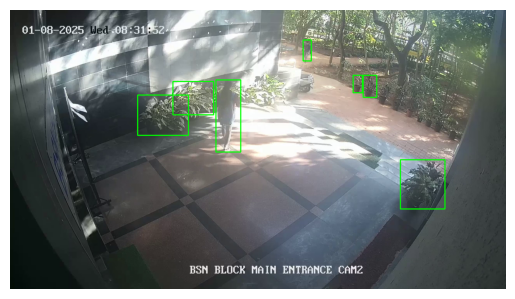

In [ ]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Change to your video filename
VIDEO_PATH = '/content/bsnentrancerawfile.mp4'  # Or '/content/drive/MyDrive/entrance.mp4'

model = YOLO('yolov8m.pt')

cap = cv2.VideoCapture(VIDEO_PATH)

ret, frame = cap.read()
if ret:
    results = model(frame)
    for box in results[0].boxes.xyxy:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
    # Show result in notebook
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
else:
    print("Failed to load video")

cap.release()

In [ ]:
import cv2
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
import matplotlib.pyplot as plt

# Load YOLOv8m model (since it works best for you)
model = YOLO('yolov8m.pt')

# Initialize DeepSORT tracker
tracker = DeepSort(max_age=30)

# Change this to your video path
VIDEO_PATH = '/content/bsnentrancerawfile.mp4'

cap = cv2.VideoCapture(VIDEO_PATH)
ret, frame = cap.read()

# Just process first frame for demo, remove this loop to process whole video
if ret:
    results = model(frame)
    detections = []
    for box, conf, class_id in zip(results[0].boxes.xyxy, results[0].boxes.conf, results[0].boxes.cls):
        if int(class_id) == 0:  # Only 'person' class
            x1, y1, x2, y2 = map(int, box)
            detections.append(([x1, y1, x2 - x1, y2 - y1], float(conf), 'person'))

    tracks = tracker.update_tracks(detections, frame=frame)
    for track in tracks:
        if not track.is_confirmed():
            continue
        track_id = track.track_id
        l, t, r, b = map(int, track.to_ltrb())
        cv2.rectangle(frame, (l, t), (r, b), (255, 0, 0), 2)
        cv2.putText(frame, f'ID:{track_id}', (l, t - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)

    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
else:
    print("Failed to load video.")
cap.release()

**Final code**

In [ ]:
#Final Code
import cv2
import random
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

# Load YOLOv8 model
model = YOLO('yolov8m.pt')

# Initialize DeepSORT tracker
# max_age = 15, maximum number of frames an object can remain undetected before it's deleted from the tracker.
# init= 3, This is the number of consecutive detections required to confirm a new track.
# max_cosine_distance=0.3,  This is a threshold for matching appearance features between detections and existing tracks.
# Initialize DeepSORT tracker
tracker = DeepSort(max_age=15, n_init=3, max_cosine_distance=0.3)

VIDEO_PATH = '/content/bsnentrancerawfile.mp4'
OUTPUT_PATH = '/content/output_tracked.mp4'

cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (width, height))
entry_line_x = 250 # Vertical line 250px from the left edge
count_in = 0
count_out = 0
track_positions = {}

# Inside the frame processing loop:

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame, conf=0.4)[0]

    detections = []
    for box in results.boxes:
        cls_id = int(box.cls[0])
        conf = float(box.conf[0])
        if cls_id == 0:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            detections.append(([x1, y1, x2 - x1, y2 - y1], conf, 'person'))

    tracks = tracker.update_tracks(detections, frame=frame)

    for track in tracks:
        if not track.is_confirmed():
            continue

        track_id = track.track_id
        x1, y1, x2, y2 = map(int, track.to_ltrb())
        cx = (x1 + x2) // 2
        cy = (y1 + y2) // 2

        prev_x = track_positions.get(track_id)
        track_positions[track_id] = cx

        if prev_x is not None:
            if prev_x > entry_line_x and cx <= entry_line_x:
                count_in += 1
            elif prev_x < entry_line_x and cx >= entry_line_x:
                count_out += 1

        # Draw bounding box with unique color
        color = get_color(track_id)
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame, f'ID: {track_id}', (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Draw vertical entry line
    cv2.line(frame, (entry_line_x, 0), (entry_line_x, height), (0, 0, 255), 2)

    # Show counts in top-left corner
    cv2.putText(frame, f'IN: {count_in}', (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 200, 0), 3)
    cv2.putText(frame, f'OUT: {count_out}', (10, 70),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)

    out.write(frame)

cap.release()
out.release()
cv2.destroyAllWindows()